In [104]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))   #COMMENT THIS TO NOT PRINT ALL DIR

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [105]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import List

In [106]:
img_path = "/kaggle/input/bossbase/boss_256_0.4/cover/100.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape: (512, 512)

In [107]:
#SRM Filter

#(3×3 kernels)
srm_filters = [
    np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]]),  # horizontal diff
    np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]]),  # vertical diff
    np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])  # laplacian-like
]

In [108]:
#Gabor Filter

def gabor_kernels(ksize=11):
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):  # 0,45,90,135 degrees
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kernels.append(kern.astype(np.float32))
    return kernels

gabor_kerns = gabor_kernels()

In [ ]:
class BossBaseDataset(Dataset):
    def __init__(self, cover_dir, stego_dir=None, transform=None):

        self.cover_files = sorted([
            os.path.join(cover_dir, f) for f in os.listdir(cover_dir) if f.lower().endswith(".png")
        ])
        self.stego_files = sorted([
            os.path.join(stego_dir, f) for f in os.listdir(stego_dir) if stego_dir and f.lower().endswith(".png")
        ]) if stego_dir else []

        self.transform = transform

        self.srm_filters = [
            np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]], dtype=np.float32),
            np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]], dtype=np.float32),
            np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]], dtype=np.float32)
        ]
        self.gabor_kerns = gabor_kernels(ksize=11)

        self.num_channels = len(self.srm_filters) + len(self.gabor_kerns) + 1

    def __len__(self):
        return len(self.cover_files) + len(self.stego_files)

    def _apply_filters(self, img):
        img_f = img.astype(np.float32)
        residuals = [cv2.filter2D(img_f, -1, k) for k in self.srm_filters]    # list of (H,W)
        gabors   = [cv2.filter2D(img_f, -1, k) for k in self.gabor_kerns]     # list of (H,W)
        residual_maps = np.stack(residuals, axis=2)   # (H, W, Cr)
        gabor_maps    = np.stack(gabors, axis=2)     # (H, W, Cg)
        return residual_maps, gabor_maps

    def __getitem__(self, idx):
        if idx < len(self.cover_files):
            img_path = self.cover_files[idx]
            label = 0.0  # cover
        else:
            img_path = self.stego_files[idx - len(self.cover_files)]
            label = 1.0  # stego

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape (H, W)
        if img is None:
            raise FileNotFoundError(f"Cannot load image: {img_path}")

        residual_maps, gabor_maps = self._apply_filters(img)

        gray_ch = img.astype(np.float32)[..., None]            # (H, W, 1)

        combined = np.concatenate([residual_maps, gabor_maps, gray_ch], axis=2)

        combined = combined.transpose(2, 0, 1).astype(np.float32)

        combined = combined / 255.0

        tensor = torch.from_numpy(combined)  # (C, H, W)

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, torch.tensor(label, dtype=torch.float32)

In [144]:
class ResidualAttentionBlock(nn.Module):
    """Block: global pooling -> 1x1 conv (reduce) -> ReLU -> 1x1 conv (expand) -> Sigmoid -> channel reweight -> 1x1 conv -> GroupNorm -> ReLU -> add residual"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # (B,C,1,1)
        self.gate = nn.Sequential(
            nn.Conv2d(channels, reduced, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        self.out_conv = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, channels), num_channels=channels)

        self.last_weights = None   #to store the attention weights

    def forward(self, x):
        s = self.global_pool(x)        # (B, C, 1, 1)
        s = self.gate(s)               # (B, C, 1, 1)
        if not self.training:          # remove this to print the ran arch for each run
            #print("Channel weights:", s.view(s.size(0), -1).detach().cpu().numpy())
            pass
        self.last_weights = s.detach().cpu().numpy()
        x_scaled = x * s             
        out = self.out_conv(x_scaled)
        out = self.norm(out)
        out = F.relu(out, inplace=True)
        return out + x              

In [145]:
class ConvBlockPool(nn.Module):
    """Conv -> ReLU -> MaxPool(2) with residual (skip downsampled)"""
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        if in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch),
                nn.AvgPool2d(kernel_size=2, stride=2)
            )
        else:
            self.skip = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        y = self.conv(x)
        y = self.norm(y)
        y = F.relu(y, inplace=True)
        y = self.pool(y)
        s = self.skip(x)
        return F.relu(y + s, inplace=True)


In [146]:
class ConvBlockGlobalPool(nn.Module):
    """Conv -> ReLU -> AdaptiveAvgPool2d(1) -> small gating -> channel-wise scaling -> residual add"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, channels), num_channels=channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.ch_gate = nn.Sequential(
            nn.Conv2d(channels, reduced, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.conv(x)
        y = self.norm(y)
        y = F.relu(y, inplace=True)
        p = self.pool(y)         # (B, C, 1, 1)
        g = self.ch_gate(p)      # (B, C, 1, 1)
        y2 = y * g               # gated
        return F.relu(y2 + x, inplace=True)

In [147]:
class ResidualAttentionNet(nn.Module):
    """
    Outputs a feature map (B, C_latent, H_out, W_out)
    """
    def __init__(self, c_in, base_ch=32):
        super().__init__()
        self.init_conv = nn.Conv2d(c_in, base_ch, kernel_size=3, padding=1, bias=False)
        self.init_norm = nn.GroupNorm(num_groups=min(8, base_ch), num_channels=base_ch)

        self.att1 = ResidualAttentionBlock(base_ch, reduction=8)
        self.convpool = ConvBlockPool(base_ch, base_ch * 2)
        self.att2 = ResidualAttentionBlock(base_ch * 2, reduction=8)
        self.globalblock = ConvBlockGlobalPool(base_ch * 2, reduction=8)

        self.project = nn.Conv2d(base_ch * 2, base_ch * 4, kernel_size=1, bias=False)
        self.project_norm = nn.GroupNorm(num_groups=min(8, base_ch * 4), num_channels=base_ch * 4)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.init_norm(x)
        x = F.relu(x, inplace=True)

        x = self.att1(x)        # (B, base_ch, H, W)
        x = self.convpool(x)    # (B, base_ch*2, H/2, W/2)
        x = self.att2(x)        # (B, base_ch*2, H/2, W/2)
        x = self.globalblock(x) # (B, base_ch*2, H/2, W/2)

        x = self.project(x)
        x = self.project_norm(x)
        x = F.relu(x, inplace=True)
        return x

In [148]:
cover_dir = "/kaggle/input/bossbase/boss_256_0.4/cover"
stego_dir = "/kaggle/input/bossbase/boss_256_0.4/stego"

dataset = BossBaseDataset(cover_dir, stego_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

c_in = dataset.num_channels

# init RAN with that channel count
ran = ResidualAttentionNet(c_in, base_ch=32) #change this base channel value accordingly

#print(ran)  # print the model repr as you did earlier

# get batches and run through RAN
for batch in dataloader:
    fused_input, labels = batch  # fused_input: (B, C, H, W)
    print("Fused input shape:", fused_input.shape)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ran = ran.to(device)
    fused_input = fused_input.to(device)

    attended_features = ran(fused_input)
    print("Attended features:", attended_features.shape)
    break

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_37/611741088.py", line 133, in __getitem__
    tensor = (tensor - channel_mean) / (channel_std + 1e-8)
              ~~~~~~~^~~~~~~~~~~~~~
RuntimeError: The size of tensor a (29) must match the size of tensor b (8) at non-singleton dimension 0


In [116]:
def visualize_attention_weights(model, cover_img, stego_img):
    with torch.no_grad():
        _ = model(cover_img.unsqueeze(0).unsqueeze(0))  # add batch+channel dims
        cover_w = model.att1.last_weights.squeeze()     # shape (C,)
        
        _ = model(stego_img.unsqueeze(0).unsqueeze(0))
        stego_w = model.att1.last_weights.squeeze()

    plt.figure(figsize=(12,5))
    idx = np.arange(len(cover_w))
    plt.bar(idx - 0.2, cover_w, width=0.4, label="Cover")
    plt.bar(idx + 0.2, stego_w, width=0.4, label="Stego")
    plt.xlabel("Channel index")
    plt.ylabel("Attention weight")
    plt.title("RAN Attention Weights: Cover vs Stego")
    plt.legend()
    plt.show()

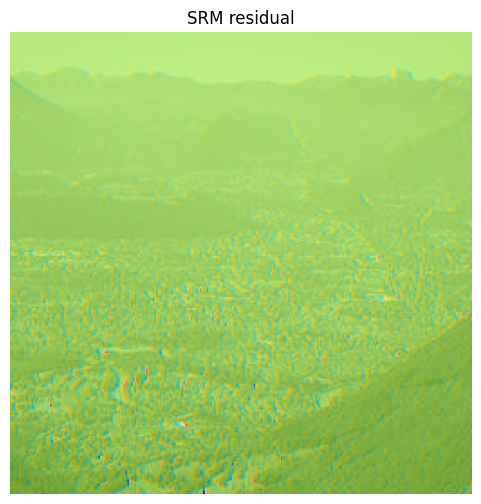

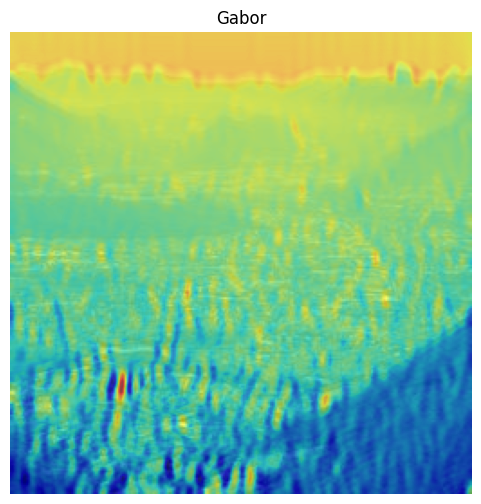

In [115]:
def extract_features(img, srm_filters, gabor_kerns):
    residual_maps = [cv2.filter2D(img.astype(np.float32), -1, f) for f in srm_filters]
    gabor_maps = [cv2.filter2D(img, cv2.CV_32F, k) for k in gabor_kerns]
    return np.stack(residual_maps, axis=-1), np.stack(gabor_maps, axis=-1)


def overlay_heatmap(original, feature_map, title="", alpha=0.6, cmap="jet"):
    """
    Overlay a feature map (residual or gabor) on top of the original image.
    """
    # Normalize feature map to [0, 1]
    norm_map = cv2.normalize(feature_map, None, 0, 1, cv2.NORM_MINMAX)

    plt.figure(figsize=(6,6))
    plt.imshow(original, cmap="gray")
    plt.imshow(norm_map, cmap=cmap, alpha=alpha)
    plt.title(title)
    plt.axis("off")
    plt.show()


residual_maps, gabor_maps = extract_features(img, srm_filters, gabor_kerns)
overlay_heatmap(img, residual_maps[..., 0], title="SRM residual")
overlay_heatmap(img, gabor_maps[..., 0], title="Gabor")

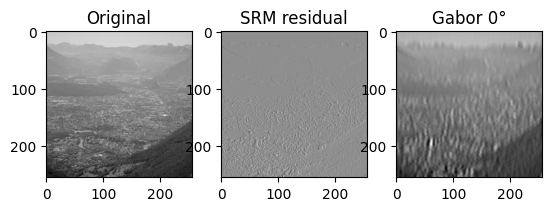

In [117]:
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

# visualize one SRM residual
plt.subplot(1, 3, 2)
plt.imshow(residual_maps[..., 0], cmap='gray')
plt.title("SRM residual")

# visualize one Gabor map
plt.subplot(1, 3, 3)
plt.imshow(gabor_maps[..., 0], cmap='gray')
plt.title("Gabor 0°")
plt.show()


# **DAN**

# Generator Branch

In [118]:
class CoverReconstructionGenerator(nn.Module):
    """Generator that reconstructs cover images from stego + residual features (RAN features).

    The generator expects `input_channels` equal to 1 (stego) + channels(features)
    where `features` should be spatially resized to match the stego image resolution
    before concatenation (DAN will handle interpolation).
    """
    def __init__(self, input_channels=8, base_ch=32, latent_ch=128):
        super().__init__()
        
        # Encoder: Process stego + features to latent space
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, base_ch, 3, padding=1, bias=False),  # input: stego + features
            nn.GroupNorm(min(8, base_ch), base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch*2), base_ch*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(base_ch*2, base_ch*4, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch*4), base_ch*4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(base_ch*4, latent_ch, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, latent_ch), latent_ch),
            nn.ReLU(inplace=True)
        )
        
        # Decoder: Reconstruct cover from latent representation
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_ch, base_ch*4, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch*4), base_ch*4),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_ch*4, base_ch*2, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch*2), base_ch*2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_ch*2, base_ch, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch), base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, 1, 3, padding=1, bias=False),  # output single channel
            nn.Sigmoid()  # output in [0,1] range
        )
        
    def forward(self, stego_img, residual_features):
        """
        Args:
            stego_img: (B, 1, H, W) - stego image
            residual_features: (B, C_feat, H, W) - features from RAN (upsampled to match H,W)
        Returns:
            reconstructed_cover: (B, 1, H, W)
        """
        # Concatenate stego with residual features along channel dimension
        x = torch.cat([stego_img, residual_features], dim=1)
        
        # Encode to latent space
        latent = self.encoder(x)
        
        # Decode to reconstruct cover
        reconstructed_cover = self.decoder(latent)
        
        return reconstructed_cover


# Testing Generaor Branch (without training)

Testing CoverReconstructionGenerator...
Input shapes:
  Stego image: torch.Size([4, 1, 256, 256])
  Residual features: torch.Size([4, 7, 256, 256])
Reconstructed cover shape: torch.Size([4, 1, 256, 256])
Reconstructed cover range: [0.140, 0.811]
Initial MSE loss (reconstructed vs stego): 2.594579


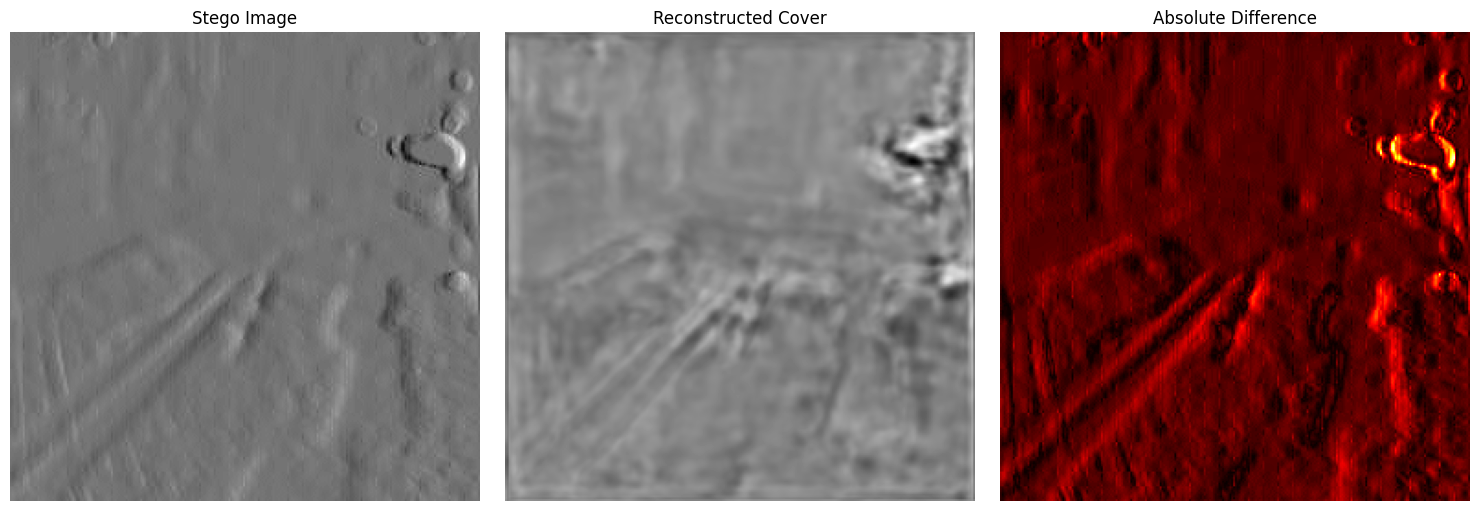

Difference stats - Min: 0.0001, Max: 4.4258, Mean: 0.5334


In [119]:
# Test the Generator
def test_generator():
    print("Testing CoverReconstructionGenerator...")
    
    # Create generator instance
    generator = CoverReconstructionGenerator(base_ch=32, latent_ch=128)
    
    # Get a batch from your dataloader
    for batch in dataloader:
        fused_input, labels = batch  # fused_input: (B, C, H, W)
        
        # Extract stego image (first channel) and residual features (remaining channels)
        stego_img = fused_input[:, 0:1, :, :]  # (B, 1, H, W) - grayscale image
        residual_features = fused_input[:, 1:, :, :]  # (B, C-1, H, W) - residual features
        
        print(f"Input shapes:")
        print(f"  Stego image: {stego_img.shape}")
        print(f"  Residual features: {residual_features.shape}")
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        generator = generator.to(device)
        stego_img = stego_img.to(device)
        residual_features = residual_features.to(device)
        
        # Forward pass through generator
        with torch.no_grad():
            reconstructed_cover = generator(stego_img, residual_features)
        
        print(f"Reconstructed cover shape: {reconstructed_cover.shape}")
        print(f"Reconstructed cover range: [{reconstructed_cover.min().item():.3f}, {reconstructed_cover.max().item():.3f}]")
        
        # Test reconstruction loss
        mse_loss = F.mse_loss(reconstructed_cover, stego_img)
        print(f"Initial MSE loss (reconstructed vs stego): {mse_loss.item():.6f}")
        
        # Visualize one example
        visualize_reconstruction(stego_img[0], reconstructed_cover[0])
        
        break

def visualize_reconstruction(stego, reconstructed):
    """Visualize stego and reconstructed images"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Convert tensors to numpy for visualization
    stego_np = stego.squeeze().cpu().numpy()
    reconstructed_np = reconstructed.squeeze().cpu().numpy()
    
    # Original stego
    axes[0].imshow(stego_np, cmap='gray')
    axes[0].set_title('Stego Image')
    axes[0].axis('off')
    
    # Reconstructed cover
    axes[1].imshow(reconstructed_np, cmap='gray')
    axes[1].set_title('Reconstructed Cover')
    axes[1].axis('off')
    
    # Difference
    diff = np.abs(stego_np - reconstructed_np)
    axes[2].imshow(diff, cmap='hot')
    axes[2].set_title('Absolute Difference')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Difference stats - Min: {diff.min():.4f}, Max: {diff.max():.4f}, Mean: {diff.mean():.4f}")

# Run the test
test_generator()

# Classifier Branch

In [120]:
class SteganalysisClassifier(nn.Module):
    """Classifier that detects stego vs cover using RAN features

    The forward accepts either a fused input `x` (image + residuals) OR precomputed
    `features` from a shared feature extractor (ResidualAttentionNet). If `features`
    is provided, the classifier skips its own local extractor and uses the features directly.
    """
    def __init__(self, input_channels, base_ch=32, num_classes=1):
        super().__init__()
        
        # Local feature_extractor (kept for backward compatibility)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_channels, base_ch, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch), base_ch),
            nn.ReLU(inplace=True),
            ResidualAttentionBlock(base_ch, reduction=8),
            ConvBlockPool(base_ch, base_ch*2),
            ResidualAttentionBlock(base_ch*2, reduction=8),
            ConvBlockGlobalPool(base_ch*2, reduction=8),
            nn.Conv2d(base_ch*2, base_ch*4, 1, bias=False),
            nn.GroupNorm(min(8, base_ch*4), base_ch*4),
            nn.ReLU(inplace=True),
        )
        
        # Classification head (operates on feature maps)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
            nn.Linear(base_ch*4, base_ch*2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(base_ch*2, num_classes)
        )
        
    def forward(self, x=None, features=None):
        """
        Args:
            x: (B, C, H, W) - fused input (image + residuals). Used when `features` is None.
            features: (B, C_feat, Hf, Wf) - precomputed features from shared extractor.
        Returns:
            logits: (B, num_classes) - classification logits
        """
        if features is None:
            if x is None:
                raise ValueError("Either `x` or `features` must be provided to the classifier.")
            features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits


# Testing Classifier Branch (without training)

In [121]:
# Test the Steganalysis Classifier
def test_classifier():
    print("Testing SteganalysisClassifier...")
    
    # Create classifier instance
    input_channels = 8  # Same as generator input
    classifier = SteganalysisClassifier(input_channels=input_channels, base_ch=32, num_classes=2)
    
    # Get a batch from your dataloader
    for batch in dataloader:
        fused_input, labels = batch  # fused_input: (B, 8, H, W), labels: (B,)
        
        print(f"Input shapes:")
        print(f"  Fused input: {fused_input.shape}")
        print(f"  Labels: {labels.shape}")
        print(f"  Labels: {labels}")
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        classifier = classifier.to(device)
        fused_input = fused_input.to(device)
        labels = labels.to(device)
        
        # Forward pass through classifier
        with torch.no_grad():
            logits = classifier(fused_input)
        
        print(f"Classifier output shapes:")
        print(f"  Logits: {logits.shape}")
        print(f"  Logits values: {logits}")
        
        # Convert logits to probabilities and predictions
        probabilities = F.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)
        
        print(f"Probabilities: {probabilities}")
        print(f"Predictions: {predictions}")
        print(f"Ground truth: {labels}")
        
        # Calculate initial accuracy
        correct = (predictions == labels).sum().item()
        accuracy = correct / len(labels)
        print(f"Initial accuracy: {accuracy:.4f} ({correct}/{len(labels)})")
        
        # Test classification loss
        classification_loss = F.cross_entropy(logits, labels.long())
        print(f"Initial classification loss: {classification_loss.item():.6f}")
        
        break

# Run the classifier test
test_classifier()

Testing SteganalysisClassifier...
Input shapes:
  Fused input: torch.Size([4, 8, 256, 256])
  Labels: torch.Size([4])
  Labels: tensor([1., 1., 0., 0.])
Classifier output shapes:
  Logits: torch.Size([4, 2])
  Logits values: tensor([[-0.4648, -0.0658],
        [-0.3866, -0.0821],
        [-0.3990, -0.0061],
        [-0.4585, -0.0790]], device='cuda:0')
Probabilities: tensor([[0.4016, 0.5984],
        [0.4244, 0.5756],
        [0.4030, 0.5970],
        [0.4063, 0.5937]], device='cuda:0')
Predictions: tensor([1, 1, 1, 1], device='cuda:0')
Ground truth: tensor([1., 1., 0., 0.], device='cuda:0')
Initial accuracy: 0.5000 (2/4)
Initial classification loss: 0.718840


# DAN Main Class

In [122]:
import torch.nn.functional as F

class DualAdversarialNetwork(nn.Module):
    """
    Replace your old DAN with this version that:
     - uses a shared RAN feature_extractor
     - feeds RAN features into classifier and generator
     - contains a PatchDiscriminator (discriminator instance is created separately below)
    """
    def __init__(self, input_channels=8, base_ch=32, latent_ch=128, num_classes=2):
        super().__init__()
        # Shared RAN
        self.feature_extractor = ResidualAttentionNet(c_in=input_channels, base_ch=base_ch)
        # Determine feature channel count used by RAN (match your RAN's projection)
        self.features_ch = base_ch * 4  # same as ResidualAttentionNet.project output channels
        
        # Branch 1: classifier (we will let it accept precomputed features)
        self.classifier = SteganalysisClassifier(input_channels, base_ch, num_classes)
        # make classifier reuse the exact feature_extractor if needed (backwards compat)
        self.classifier.feature_extractor = self.feature_extractor

        # Branch 2: generator: accepts (1 + features_ch) channels after upsampling features to image res
        self.generator = CoverReconstructionGenerator(input_channels=(1 + self.features_ch), base_ch=base_ch, latent_ch=latent_ch)

        # Discriminator (patch)
        self.discriminator = PatchDiscriminator(in_ch=1, base_ch=base_ch)

    def forward(self, fused_input, stego_img=None, use_generator=True):
        """
        fused_input: (B, C=8, H, W)
        stego_img: (B,1,H,W) optional - if None and generator requested, derived from fused_input first channel
        returns dict: classification_logits, reconstructed_cover (or None), features (RAN output)
        """
        if use_generator and stego_img is None:
            stego_img = fused_input[:, :1, :, :]

        # RAN features
        features = self.feature_extractor(fused_input)   # (B, features_ch, Hf, Wf)

        # Classifier uses features directly (this requires classifier to accept features argument)
        try:
            classification_logits = self.classifier(features=features)
        except TypeError:
            classification_logits = self.classifier(fused_input)

        reconstructed_cover = None
        if use_generator and stego_img is not None:
            target_sp = stego_img.shape[-2:]
            up_features = F.interpolate(features, size=target_sp, mode='bilinear', align_corners=False)
            reconstructed_cover = self.generator(stego_img, up_features)

        return {
            'classification_logits': classification_logits,
            'reconstructed_cover': reconstructed_cover,
            'features': features
        }


In [123]:
import torch.nn as nn
class PatchDiscriminator(nn.Module):
    """Small patch discriminator returning a single logit per image"""
    def __init__(self, in_ch=1, base_ch=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch, base_ch*2, 3, stride=2, padding=1),
            nn.GroupNorm(min(8, base_ch*2), base_ch*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch*2, base_ch*4, 3, stride=2, padding=1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_ch*4, 1)
        )
    def forward(self, x):
        # returns logits (not sigmoided)
        return self.net(x).view(-1)


In [124]:
# Test the complete Dual-Adversarial Network
def test_dan():
    print("Testing DualAdversarialNetwork...")
    
    # Create DAN instance
    dan = DualAdversarialNetwork(input_channels=8, base_ch=32)
    
    # Get a batch from your dataloader
    for batch in dataloader:
        fused_input, labels = batch
        
        print(f"Input shape: {fused_input.shape}")
        print(f"Labels: {labels}")
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dan = dan.to(device)
        fused_input = fused_input.to(device)
        labels = labels.to(device)
        
        # Test with generator
        print("\n--- Testing with Generator ---")
        with torch.no_grad():
            outputs = dan(fused_input, use_generator=True)
 
        
        print(f"Classification logits shape: {outputs['classification_logits'].shape}")
        print(f"Reconstructed cover shape: {outputs['reconstructed_cover'].shape}")
        print(f"Features shape: {outputs['features'].shape}")
        
        # Test without generator
        print("\n--- Testing without Generator ---")
        with torch.no_grad():
            outputs_no_gen = dan(fused_input, use_generator=False)
        
        print(f"Classification logits shape: {outputs_no_gen['classification_logits'].shape}")
        print(f"Reconstructed cover: {outputs_no_gen['reconstructed_cover']}")
        
        break

# Run the DAN test
test_dan()

Testing DualAdversarialNetwork...
Input shape: torch.Size([4, 8, 256, 256])
Labels: tensor([1., 0., 1., 0.])

--- Testing with Generator ---
Classification logits shape: torch.Size([4, 2])
Reconstructed cover shape: torch.Size([4, 1, 256, 256])
Features shape: torch.Size([4, 128, 128, 128])

--- Testing without Generator ---
Classification logits shape: torch.Size([4, 2])
Reconstructed cover: None


# DAN Loss

In [125]:
class DANLoss(nn.Module):
    #initial values 
    #alpha = 1.0 beta = 1.0 gamma = 0.05
    def __init__(self, alpha=1.0, beta= 0.2, gamma=0.02, lambda_consistency=2.0):
        """
        alpha: classification weight
        beta: reconstruction (L1) weight
        gamma: adversarial generator weight
        lambda_consistency: extra weight for consistency if used
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.lambda_consistency = lambda_consistency

        self.classification_loss = nn.CrossEntropyLoss()
        self.reconstruction_loss = nn.L1Loss()
        self.bce_adv = nn.BCEWithLogitsLoss()

    def generator_losses(self, outputs, labels, discriminator=None, cover_images=None):
        """
        Used for generator+classifier update (G step)
        """
        losses = {}
        logits = outputs['classification_logits']
        recon = outputs.get('reconstructed_cover', None)

        losses['classification_loss'] = self.classification_loss(logits, labels)

        if (recon is not None) and (cover_images is not None):
            losses['reconstruction_loss'] = self.reconstruction_loss(recon, cover_images)
        else:
            losses['reconstruction_loss'] = torch.tensor(0.0, device=logits.device)

        # adversarial generator loss (generator tries to make discriminator predict real)
        if (recon is not None) and (discriminator is not None):
            pred_fake = discriminator(recon)
            real_label = torch.ones_like(pred_fake, device=pred_fake.device)
            losses['adv_gen_loss'] = self.bce_adv(pred_fake, real_label)
        else:
            losses['adv_gen_loss'] = torch.tensor(0.0, device=logits.device)

        # total for generator-classifier update
        total = (self.alpha * losses['classification_loss']
                 + self.beta * losses['reconstruction_loss']
                 + self.gamma * losses['adv_gen_loss'])
        losses['total'] = total
        return losses

    def discriminator_loss(self, discriminator, recon, cover_images):
        """
        Used for discriminator update (D step)
        """
        if recon is None or cover_images is None:
            return torch.tensor(0.0, device=next(discriminator.parameters()).device)
        pred_real = discriminator(cover_images)
        pred_fake = discriminator(recon.detach())
        real_label = torch.ones_like(pred_real, device=pred_real.device)
        fake_label = torch.zeros_like(pred_fake, device=pred_fake.device)
        loss = self.bce_adv(pred_real, real_label) + self.bce_adv(pred_fake, fake_label)
        return loss


In [126]:
class DANTrainer:
    def __init__(self, model, train_loader, val_loader=None, device=None, lr_G=5e-6, lr_D=1e-5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

        # separate optimizers: G includes generator + classifier + RAN (feature_extractor)
        params_G = list(self.model.generator.parameters()) + \
                   list(self.model.classifier.parameters()) + \
                   list(self.model.feature_extractor.parameters())
        self.opt_G = torch.optim.AdamW(params_G, lr=lr_G, weight_decay=1e-4)
        self.opt_D = torch.optim.AdamW(self.model.discriminator.parameters(), lr=lr_D, weight_decay=1e-4)

        self.criterion = DANLoss(alpha=1.0, beta=0.2, gamma=0.02, lambda_consistency=1.0)

        # logging
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.class_losses = []
        self.recon_losses = []
        self.adv_gen_losses = []
        self.d_losses = []

    def train_epoch(self, epoch, clip_grad=None):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0
    
        for batch_idx, batch in enumerate(self.train_loader):
            # Expecting dataset to return: fused, stego, cover, label OR fused, label
            if len(batch) == 4:
                fused_input, stego_img, cover_images, labels = batch
            else:
                fused_input, labels = batch
                stego_img = fused_input[:, :1, :, :]
                cover_images = fused_input[:, :1, :, :]
    
            # Move to device
            fused_input = fused_input.to(self.device)
            stego_img = stego_img.to(self.device)
            cover_images = cover_images.to(self.device)
    
            # ---- Robust label handling ----
            # Accept labels as float/int, shape (N,) or (N,1), convert to LongTensor of shape (N,)
            labels = labels.to(self.device)
            # if labels has shape (N,1) -> squeeze to (N,)
            if labels.dim() > 1:
                labels = labels.view(-1)
            # convert floats (0.0/1.0) to long indices 0/1
            if labels.dtype != torch.long:
                labels = labels.long()
            # -------------------------------
    
            # 1) Generator + Classifier (G) update
            self.opt_G.zero_grad()
            outputs = self.model(fused_input, stego_img=stego_img, use_generator=True)
            losses = self.criterion.generator_losses(outputs, labels, discriminator=self.model.discriminator, cover_images=cover_images)
            loss_G = losses['total']
            loss_G.backward()
            if clip_grad is not None:
                # params_G must be accessible in this scope (define in __init__ if used)
                torch.nn.utils.clip_grad_norm_(params_G, clip_grad)
            self.opt_G.step()
    
            # 2) Discriminator (D) update
            recon = outputs.get('reconstructed_cover', None)
            self.opt_D.zero_grad()
            loss_D = self.criterion.discriminator_loss(self.model.discriminator, recon, cover_images)
            if isinstance(loss_D, torch.Tensor) and loss_D.requires_grad:
                loss_D.backward()
            self.opt_D.step()
    
            # Logging
            total_loss += loss_G.item() if isinstance(loss_G, torch.Tensor) else float(loss_G)
            self.class_losses.append(losses['classification_loss'].item() if isinstance(losses['classification_loss'], torch.Tensor) else float(losses['classification_loss']))
            self.recon_losses.append(losses['reconstruction_loss'].item() if isinstance(losses['reconstruction_loss'], torch.Tensor) else float(losses['reconstruction_loss']))
            self.adv_gen_losses.append(losses['adv_gen_loss'].item() if isinstance(losses['adv_gen_loss'], torch.Tensor) else float(losses['adv_gen_loss']))
            self.d_losses.append(loss_D.item() if isinstance(loss_D, torch.Tensor) else float(loss_D))
    
            preds = torch.argmax(outputs['classification_logits'], dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
            if batch_idx % 20 == 0:
                print(f"Epoch {epoch} | Batch {batch_idx}/{len(self.train_loader)} | Loss_G: {loss_G.item():.4f} | Loss_D: {loss_D.item():.4f}")
    
        epoch_loss = total_loss / len(self.train_loader)
        epoch_acc = correct / total
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc


    def validate(self, epoch):
        if self.val_loader is None:
            return None, None
        self.model.eval()
        total=0; correct=0; total_loss=0.0
        with torch.no_grad():
            for fused_input, stego_img, cover_images, labels in self.val_loader:
                fused_input = fused_input.to(self.device)
                stego_img = stego_img.to(self.device)
                cover_images = cover_images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(fused_input, stego_img=stego_img, use_generator=False)
                loss_dict = self.criterion.generator_losses(outputs, labels, discriminator=None, cover_images=None)
                total_loss += loss_dict['total'].item()
                preds = torch.argmax(outputs['classification_logits'], dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        epoch_loss = total_loss / len(self.val_loader)
        epoch_acc = correct/total
        self.val_losses.append(epoch_loss)
        self.val_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc

    def train(self, num_epochs=10):
        for epoch in range(1, num_epochs+1):
            with torch.no_grad():
                outputs = dan(fused.to(device), use_generator=False)
                logits = outputs['classification_logits']   # shape (B,2)
                probs = torch.softmax(logits, dim=1)
                print("logits mean/std:", logits.mean().item(), logits.std().item())
                print("probs mean:", probs.mean(dim=0).cpu().numpy())   # distribution per class
                preds = torch.argmax(probs, dim=1)
                print("sample preds:", preds.cpu().numpy())
                print("labels:", labels.cpu().numpy())
                
            train_loss, train_acc = self.train_epoch(epoch)
            print(f"Epoch {epoch} done. Train loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
            if self.val_loader:
                val_loss, val_acc = self.validate(epoch)
                print(f"  Val loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


In [127]:
print(labels.shape)

torch.Size([4])


# Final Visualization

Testing Visualizations...


/usr/local/lib/python3.11/dist-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


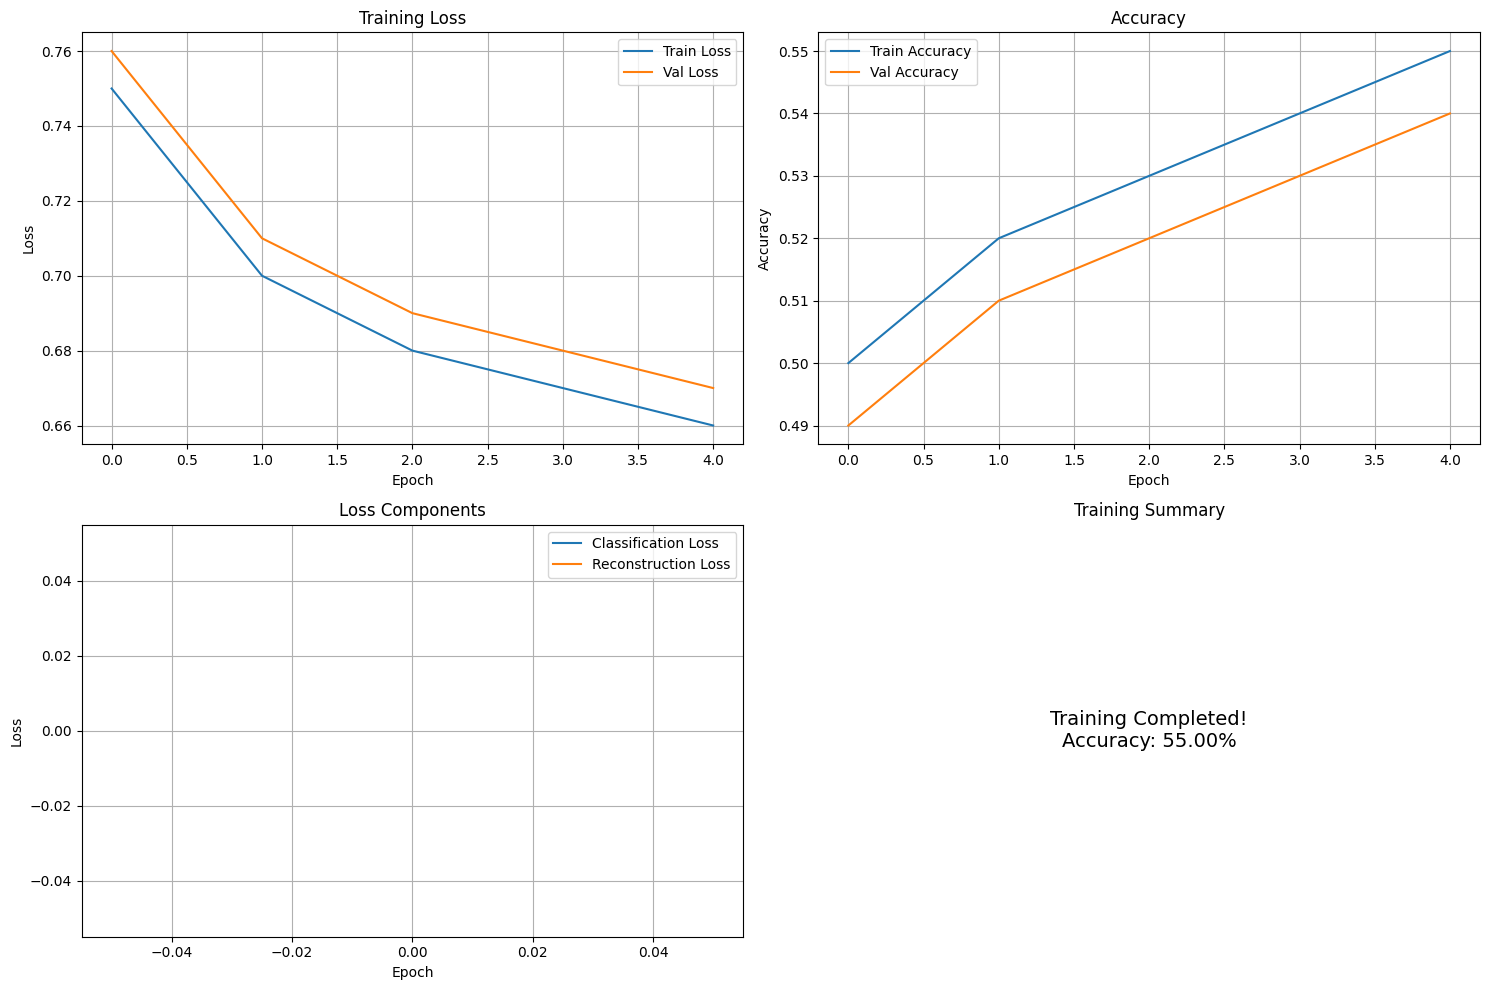

Channel weights: [[0.5739877  0.537389   0.49854323 0.546279   0.47289538 0.47763175
  0.58150107 0.4888722  0.5855619  0.49003825 0.45212388 0.56225854
  0.4964719  0.5251346  0.45438752 0.57133216 0.49553245 0.46640432
  0.49500412 0.50984555 0.5555901  0.45056304 0.45190677 0.5703702
  0.4441137  0.43605483 0.4907243  0.46204367 0.5408056  0.43478274
  0.57439524 0.48960236]
 [0.52338755 0.49666357 0.5102855  0.5071058  0.48990533 0.50090677
  0.5263205  0.48753628 0.52040064 0.5119602  0.49759597 0.5133652
  0.49262515 0.49273404 0.48675922 0.5220971  0.49440563 0.48011997
  0.5031674  0.5142708  0.5255457  0.4961839  0.47645557 0.52236915
  0.4869282  0.48900843 0.49688938 0.479228   0.51138204 0.4857353
  0.5197665  0.5122497 ]
 [0.57115823 0.5285222  0.50534475 0.5423767  0.47184917 0.48201182
  0.5800773  0.48420632 0.57935995 0.4987866  0.4579463  0.5559224
  0.49215254 0.5150984  0.45738673 0.5690794  0.49532312 0.46321696
  0.49798185 0.51596075 0.5587587  0.45767087 0.44897

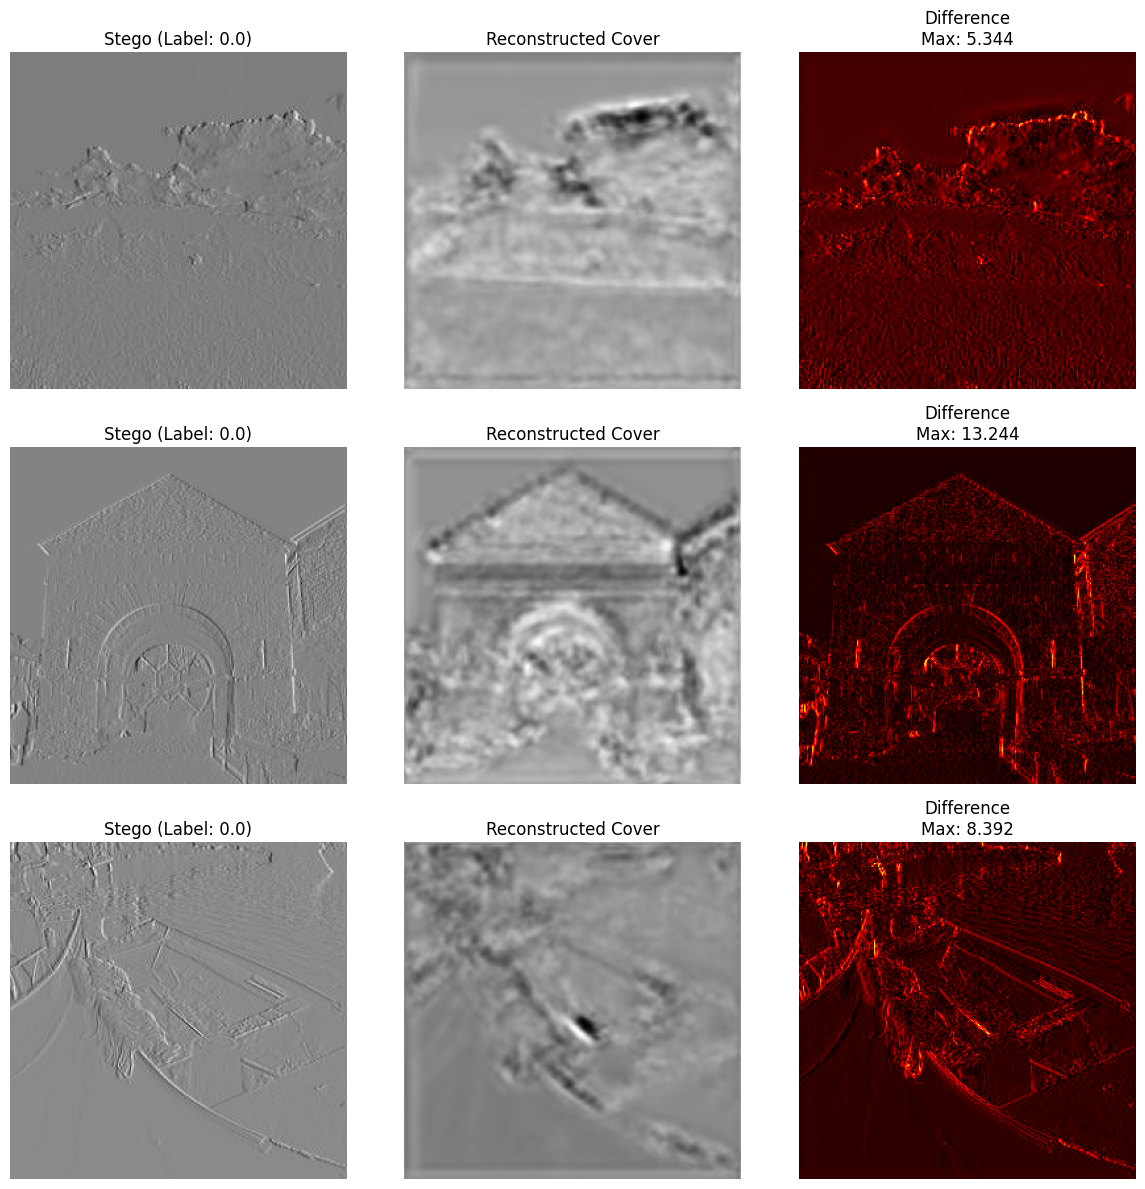

In [128]:
def visualize_training_results(trainer):
    """Visualize training progress"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training loss
    axes[0, 0].plot(trainer.train_losses, label='Train Loss')
    if trainer.val_losses:
        axes[0, 0].plot(trainer.val_losses, label='Val Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot accuracy
    axes[0, 1].plot(trainer.train_accuracies, label='Train Accuracy')
    if trainer.val_accuracies:
        axes[0, 1].plot(trainer.val_accuracies, label='Val Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot loss components (if available)
    if hasattr(trainer, 'class_losses') and hasattr(trainer, 'recon_losses'):
        axes[1, 0].plot(trainer.class_losses, label='Classification Loss')
        axes[1, 0].plot(trainer.recon_losses, label='Reconstruction Loss')
        axes[1, 0].set_title('Loss Components')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Plot learning rate (if available)
    axes[1, 1].text(0.5, 0.5, 'Training Completed!\nAccuracy: {:.2f}%'.format(trainer.train_accuracies[-1]*100), 
                   horizontalalignment='center', verticalalignment='center', 
                   transform=axes[1, 1].transAxes, fontsize=14)
    axes[1, 1].set_title('Training Summary')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_sample_reconstructions(model, dataloader, device='cuda', num_samples=3):
    """Visualize original vs reconstructed images"""
    model.eval()
    
    # Get a batch
    for fused_input, labels in dataloader:
        fused_input = fused_input.to(device)
        
        with torch.no_grad():
            outputs = model(fused_input, use_generator=True)
        
        stego_images = fused_input[:, 0:1, :, :]
        reconstructed = outputs['reconstructed_cover']
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
        
        for i in range(num_samples):
            if i >= len(stego_images):
                break
                
            # Original stego
            stego_np = stego_images[i].squeeze().cpu().numpy()
            axes[i, 0].imshow(stego_np, cmap='gray')
            axes[i, 0].set_title(f'Stego (Label: {labels[i].item()})')
            axes[i, 0].axis('off')
            
            # Reconstructed
            recon_np = reconstructed[i].squeeze().cpu().numpy()
            axes[i, 1].imshow(recon_np, cmap='gray')
            axes[i, 1].set_title('Reconstructed Cover')
            axes[i, 1].axis('off')
            
            # Difference
            diff = np.abs(stego_np - recon_np)
            axes[i, 2].imshow(diff, cmap='hot')
            axes[i, 2].set_title(f'Difference\nMax: {diff.max():.3f}')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        break

# Test the visualizations
def test_visualizations():
    """Test visualization functions"""
    print("Testing Visualizations...")
    
    # Create a simple trainer instance for visualization
    dan = DualAdversarialNetwork(input_channels=8, base_ch=32)
    trainer = DANTrainer(dan, dataloader, device='cuda')
    
    # Add some dummy data for visualization
    trainer.train_losses = [0.75, 0.70, 0.68, 0.67, 0.66]
    trainer.train_accuracies = [0.50, 0.52, 0.53, 0.54, 0.55]
    trainer.val_losses = [0.76, 0.71, 0.69, 0.68, 0.67]
    trainer.val_accuracies = [0.49, 0.51, 0.52, 0.53, 0.54]
    
    # Visualize training progress
    visualize_training_results(trainer)
    
    # Visualize sample reconstructions
    visualize_sample_reconstructions(dan, dataloader, device='cuda')


# Run visualization test
test_visualizations()

# Testing Code (WIP)

In [135]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
import cv2
from torch.utils.data import DataLoader

# ---- 1) Prepare dataset + dataloader ----
cover_dir = "/kaggle/input/bossbase/boss_256_0.4/cover"   # adjust if needed
stego_dir  = "/kaggle/input/bossbase/boss_256_0.4/stego"   # adjust if needed

# Use your existing BossBaseDataset class (no changes required).
dataset = BossBaseDataset(cover_dir=cover_dir, stego_dir=stego_dir, transform=None)
c_in = dataset.num_channels   # number of channels RAN expects (important)

batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# ---- 2) Instantiate RAN + DAN and share the feature extractor ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_ch = 32
latent_ch = 128
num_classes = 2

# Create RAN (ResidualAttentionNet) with dataset channel count
#ran = ResidualAttentionNet(c_in, base_ch=base_ch).to(device)
for param in ran.parameters():
    param.requires_grad = True

# Create DAN and *inject* the pre-created RAN (share weights)
dan = DualAdversarialNetwork(input_channels=c_in, base_ch=base_ch, latent_ch=latent_ch, num_classes=num_classes).to(device)

# Replace DAN's internal extractor with our ran instance (sharing)
dan.feature_extractor = ran
# Ensure classifier uses shared extractor if it has attribute
if hasattr(dan.classifier, 'feature_extractor'):
    print("Classifier using shared extractor")
    dan.classifier.feature_extractor = ran

# ---- 3) Trainer setup (uses DANLoss as previously defined) ----
# We'll reuse the DANTrainer class logic but create an instance here (it must be defined in notebook)
trainer = DANTrainer(dan, dataloader, val_loader=None, device=device, lr_G=1e-4, lr_D=2e-4)

Classifier using shared extractor


In [136]:
# run once in your training cell before training to inspect
batch = next(iter(dataloader))
print("Batch elements:", len(batch))
if len(batch) == 4:
    fused, stego, cover, labels = batch
else:
    fused, labels = batch
print("fused shape:", fused.shape)
print("labels shape:", labels.shape, "dtype:", labels.dtype, "unique:", torch.unique(labels))


Batch elements: 2
fused shape: torch.Size([4, 8, 256, 256])
labels shape: torch.Size([4]) dtype: torch.float32 unique: tensor([0., 1.])


In [95]:
sample_batch = next(iter(dataloader))
print("Sample batch elements count:", len(sample_batch))
if len(sample_batch) == 4:
    fused_input, stego_img, cover_images, labels = sample_batch
    print("Shapes: fused", fused_input.shape, "stego", stego_img.shape, "cover", cover_images.shape, "labels", labels.shape)
else:
    fused_input, labels = sample_batch
    print("Shapes: fused", fused_input.shape, "labels", labels.shape)
print("dataset.num_channels:", c_in)

Sample batch elements count: 2
Shapes: fused torch.Size([4, 8, 256, 256]) labels torch.Size([4])
dataset.num_channels: 8


In [101]:
# Unfreeze classifier and RAN; freeze generator/discriminator
for p in dan.generator.parameters(): p.requires_grad = False
for p in dan.discriminator.parameters(): p.requires_grad = False
for p in dan.feature_extractor.parameters(): p.requires_grad = True
for p in dan.classifier.parameters(): p.requires_grad = True

optimizer_cls = torch.optim.AdamW(
    list(dan.classifier.parameters()) + list(dan.feature_extractor.parameters()),
    lr=5e-5, weight_decay=1e-5
)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(10):
    dan.train()
    running_loss, correct, total = 0.0, 0, 0
    for fused, labels in dataloader:
        fused, labels = fused.to(device), labels.long().to(device)
        out = dan(fused, use_generator=False)
        logits = out['classification_logits']
        loss = loss_fn(logits, labels)
        optimizer_cls.zero_grad(); loss.backward(); optimizer_cls.step()
        running_loss += loss.item() * fused.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    print(f"Warmup epoch {epoch+1}: loss={running_loss/total:.4f} acc={correct/total:.4f}")

Warmup epoch 1: loss=0.6934 acc=0.4971
Warmup epoch 2: loss=0.6932 acc=0.5032
Warmup epoch 3: loss=0.6934 acc=0.4952
Warmup epoch 4: loss=0.6932 acc=0.5021
Warmup epoch 5: loss=0.6933 acc=0.5009
Warmup epoch 6: loss=0.6933 acc=0.4973
Warmup epoch 7: loss=0.6932 acc=0.5026
Warmup epoch 8: loss=0.6932 acc=0.4995
Warmup epoch 9: loss=0.6933 acc=0.4957
Warmup epoch 10: loss=0.6932 acc=0.4984


In [69]:
# ---- 4) Train for N epochs using trainer.train(num_epochs) ----
NUM_EPOCHS = 10
print("Beginning training for", NUM_EPOCHS, "epochs ...")
trainer.train(num_epochs=NUM_EPOCHS)
print("Training finished.")

##SO FAR YOU ARE USING INSTANCE OF "ResidualAttentionNet" , "ran" which have used before, 
##there is another instance "ran" which is commented two cells above, try that instance also

Beginning training for 10 epochs ...
logits mean/std: -0.09698688983917236 0.09820986539125443
probs mean: [0.46693844 0.5330615 ]
sample preds: [1 1 1 1]
labels: [1. 1. 1. 0.]
Epoch 1 | Batch 0/4500 | Loss_G: 1.3309 | Loss_D: 1.3637
Epoch 1 | Batch 20/4500 | Loss_G: 1.0857 | Loss_D: 0.0161
Epoch 1 | Batch 40/4500 | Loss_G: 1.2658 | Loss_D: 0.0024
Epoch 1 | Batch 60/4500 | Loss_G: 1.1455 | Loss_D: 0.0038
Epoch 1 | Batch 80/4500 | Loss_G: 1.1631 | Loss_D: 0.0033
Epoch 1 | Batch 100/4500 | Loss_G: 1.1478 | Loss_D: 0.0028
Epoch 1 | Batch 120/4500 | Loss_G: 1.1892 | Loss_D: 0.0033
Epoch 1 | Batch 140/4500 | Loss_G: 1.0937 | Loss_D: 0.0035
Epoch 1 | Batch 160/4500 | Loss_G: 0.9957 | Loss_D: 0.0080
Epoch 1 | Batch 180/4500 | Loss_G: 1.0385 | Loss_D: 0.0047
Epoch 1 | Batch 200/4500 | Loss_G: 1.0381 | Loss_D: 0.0062
Epoch 1 | Batch 220/4500 | Loss_G: 1.1555 | Loss_D: 0.0068
Epoch 1 | Batch 240/4500 | Loss_G: 1.0759 | Loss_D: 0.0044
Epoch 1 | Batch 260/4500 | Loss_G: 0.7761 | Loss_D: 0.3265
Epo

KeyboardInterrupt: 

In [41]:
# ---- 5) Save model checkpoint (optional) ----
torch.save({
    'dan_state_dict': dan.state_dict(),
    'ran_state_dict': ran.state_dict(),
    'trainer_state': {
        'train_losses': trainer.train_losses,
        'train_accuracies': trainer.train_accuracies
    }
}, "/kaggle/working/dan_checkpoint.pth")


Channel weights: [[0.5413723  0.52001506 0.506902   0.5242102  0.46590745 0.5377297
  0.47768635 0.5160649  0.48774117 0.49855578 0.51437336 0.5048015
  0.5461171  0.47884032 0.5021932  0.53163034 0.47219294 0.5336347
  0.52013487 0.50630844 0.46895915 0.49113733 0.45213348 0.5251376
  0.47123507 0.5308037  0.49640763 0.47245336 0.5424114  0.50842667
  0.48249644 0.53102684]]
Channel weights: [[0.29319048 0.50961846 0.48396206 0.40507156 0.5915035  0.3120065
  0.41799828 0.23031817 0.77596456 0.37552214 0.44033393 0.40611395
  0.6774099  0.4509085  0.3948162  0.21586755 0.5688386  0.67930645
  0.32825565 0.25198048 0.5710883  0.3537469  0.5795546  0.6371636
  0.7296816  0.8179112  0.3422205  0.43086213 0.49752975 0.46954408
  0.6114008  0.6059706  0.24234098 0.2405137  0.35218668 0.71023846
  0.777168   0.41683295 0.8228397  0.73931277 0.539737   0.45300946
  0.43628392 0.6027136  0.5883365  0.6791454  0.22461605 0.5283388
  0.46867344 0.34011525 0.76922214 0.52046126 0.31873798 0.6098

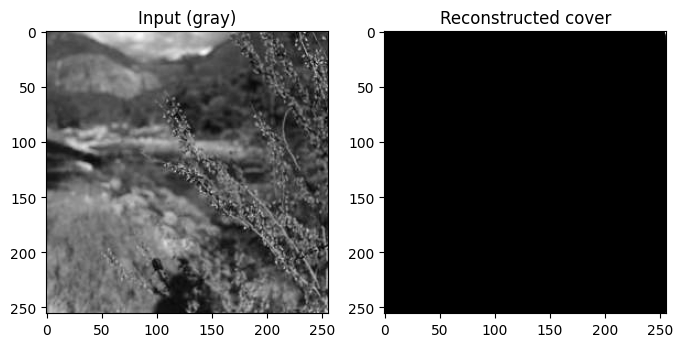

{'prob_stego': 0.48902904987335205, 'pred': 0, 'reconstructed': array([[8.1748631e-06, 6.5355096e-08, 5.2166886e-08, ..., 9.5953979e-08,
        2.0097137e-07, 2.9761677e-05],
       [1.3550933e-05, 1.7128319e-07, 2.4025525e-07, ..., 1.1351044e-05,
        2.4391600e-05, 7.1772741e-04],
       [2.6760877e-06, 1.5161492e-08, 2.3955645e-08, ..., 6.4433316e-06,
        1.5187115e-05, 4.8418422e-04],
       ...,
       [1.4340252e-06, 6.1022405e-09, 1.1086504e-08, ..., 4.1921169e-09,
        4.3795714e-09, 1.6690694e-06],
       [1.7697866e-06, 6.4714016e-09, 8.4646103e-09, ..., 3.6741441e-09,
        3.1622218e-09, 1.1540823e-06],
       [2.7731195e-04, 4.5259330e-06, 2.9151722e-06, ..., 1.2962162e-06,
        1.1620583e-06, 7.4381183e-05]], dtype=float32)}


In [45]:
def compute_residual_maps_and_fused(img_gray_np):
    """
    img_gray_np: numpy array HxW (uint8 or float)
    returns fused tensor (C,H,W) same as dataset output
    """
    # reuse the same filters used in BossBaseDataset if available; otherwise build small kernels
    # We'll attempt to reuse dataset._apply_filters if it exists:
    try:
        residuals, gabors = dataset._apply_filters(img_gray_np)
        fused_np = np.concatenate([residuals, gabors, img_gray_np[..., None]], axis=2)
    except Exception:
        # fallback small set (3 residual kernels + 4 dummy gabors)
        kernels = [
            np.array([[0,0,0],[0,1,-1],[0,0,0]], dtype=np.float32),
            np.array([[0,0,0],[0,1,0],[0,-1,0]], dtype=np.float32),
            np.array([[1,-2,1],[-2,4,-2],[1,-2,1]], dtype=np.float32)
        ]
        residuals = [cv2.filter2D(img_gray_np.astype(np.float32), -1, k) for k in kernels]
        # make 4 placeholder gabor-like filters (use Sobel/Prewitt approximations for variety)
        gabor_like = [
            cv2.Sobel(img_gray_np.astype(np.float32), cv2.CV_32F, 1, 0, ksize=3),
            cv2.Sobel(img_gray_np.astype(np.float32), cv2.CV_32F, 0, 1, ksize=3),
            cv2.Laplacian(img_gray_np.astype(np.float32), cv2.CV_32F),
            cv2.filter2D(img_gray_np.astype(np.float32), -1, np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float32))
        ]
        fused_np = np.stack(residuals + gabor_like + [img_gray_np.astype(np.float32)], axis=2)
        fused_np = fused_np.transpose(1,2,0) if fused_np.ndim==3 and fused_np.shape[2] != img_gray_np.shape[1] else fused_np
        # If shapes not matching expected channel count, pad/truncate as needed
    # Normalize
    fused_np = fused_np.astype(np.float32) / 255.0
    fused = torch.from_numpy(fused_np.transpose(2,0,1)).float()  # (C,H,W)
    # If channel count differs from dataset.num_channels, adjust by trunc/pad
    if fused.shape[0] != c_in:
        C = fused.shape[0]
        if C > c_in:
            fused = fused[:c_in, :, :]
        else:
            pad = torch.zeros((c_in - C, fused.shape[1], fused.shape[2]), dtype=fused.dtype)
            fused = torch.cat([fused, pad], dim=0)
    return fused

def test_image(image_path, model=dan, ran_extractor=ran, device=device, show=False):
    """
    Loads image_path (single image), computes fused channels, runs RAN->DAN,
    returns: {'prob': float, 'pred': int, 'reconstructed': numpy array (H,W) or None}
    """
    model.eval()
    ran_extractor.eval()
    img = Image.open(image_path).convert("L")
    img_np = np.array(img)
    fused = compute_residual_maps_and_fused(img_np)    # (C,H,W)
    fused = fused.unsqueeze(0).to(device)              # (1,C,H,W)

    with torch.no_grad():
        outputs = model(fused, use_generator=True)     # model will run RAN internally (shared)
        logits = outputs['classification_logits']      # shape (1,2) expected
        probs = F.softmax(logits, dim=1)
        prob_stego = probs[0,1].item()
        pred = int(torch.argmax(logits, dim=1).item())

        recon = outputs.get('reconstructed_cover', None)
        recon_np = None
        if recon is not None:
            recon_np = recon.squeeze(0).squeeze(0).cpu().numpy()  # (H,W)
            # clip to 0..1
            recon_np = np.clip(recon_np, 0.0, 1.0)

    if show:
        print(f"Predicted class: {pred} (prob stego={prob_stego:.4f})")
        if recon_np is not None:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(1,2, figsize=(8,4))
            ax[0].imshow(img_np, cmap='gray'); ax[0].set_title('Input (gray)')
            ax[1].imshow(recon_np, cmap='gray'); ax[1].set_title('Reconstructed cover')
            plt.show()

    return {'prob_stego': prob_stego, 'pred': pred, 'reconstructed': recon_np}

# Example usage:
result = test_image("/kaggle/input/bossbase/boss_256_0.4_test/stego/9001.png", show=True)
print(result)